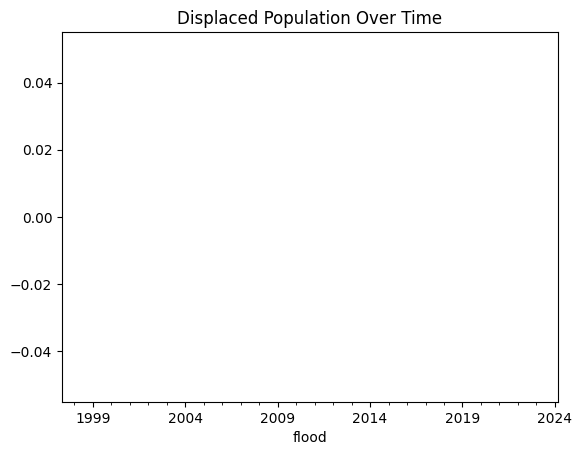

/tmp/ipykernel_95956/1697746547.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  displaced_series = displaced_series.fillna(method='ffill')
/home/pythonqueen/flood_prediction/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/pythonqueen/flood_prediction/venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:4318: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pythonqueen/flood_prediction/venv/lib/python3.10/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/pythonqueen/fl

                               SARIMAX Results                                
Dep. Variable:          displaced_(k)   No. Observations:                  323
Model:                 ARIMA(1, 1, 0)   Log Likelihood                   0.000
Date:                Wed, 16 Oct 2024   AIC                              4.000
Time:                        20:28:25   BIC                             11.549
Sample:                    05-31-1997   HQIC                             7.014
                         - 03-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0        nan        nan        nan         nan         nan
sigma2            nan        nan        nan        nan         nan         nan
Ljung-Box (L1) (Q):                    nan   Jarque-

LinAlgError: Schur decomposition solver error.

In [10]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load your flood data
data_path = '../data/processed/cleaned_flood_data.csv'
flood_data = pd.read_csv(data_path)

# Check if there are enough data points
if len(displaced_series) < 30:
    print("Not enough data points to fit ARIMA model.")
else:
    # Visualize the series
    displaced_series.plot(title='Displaced Population Over Time')
    plt.show()

    # Handle missing values (if any)
    displaced_series = displaced_series.fillna(method='ffill')

    # Fit a simpler ARIMA model
    try:
        model = ARIMA(displaced_series, order=(1, 1, 0))  # Start with a simpler model
        model_fit = model.fit()
        print(model_fit.summary())

        # Forecasting
        years_forecasted = pd.date_range(displaced_series.index[-1], periods=10, freq='Y')
        forecast = model_fit.forecast(steps=10)
        print(forecast)
    except Exception as e:
        print(f"An error occurred: {e}")

# Preprocess the data
# Convert 'flood' to datetime format
flood_data['flood'] = pd.to_datetime(flood_data['flood'])
flood_data.set_index('flood', inplace=True)

# Remove duplicates by aggregating, you can choose an aggregation method
flood_data = flood_data.groupby(flood_data.index).mean()

# Create a time series for displaced population
displaced_series = flood_data['displaced_(k)']

# Ensure the index has a frequency (Monthly End)
displaced_series = displaced_series.asfreq('ME')

# Fit ARIMA model
model = ARIMA(displaced_series, order=(5, 1, 0))
model_fit = model.fit()

# Forecasting
years_forecasted = pd.date_range(displaced_series.index[-1], periods=10, freq='Y')
forecast = model_fit.forecast(steps=10)

# Print forecast results
print("Forecasted Displaced Population for Next 10 Years:")
for year, value in zip(years_forecasted, forecast):
    print(f"{year.year}: {value}")

# Preparing data for Random Forest Classification
# Assuming 'killed' is your target variable
X = flood_data[['duration(days)', 'exposed_(mn)']]  # Features
y = flood_data['killed']  # Target variable (binary classification)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicting with Random Forest
# Create a DataFrame for future years predictions
future_years = pd.DataFrame({
    'duration(days)': [30] * 10,  # Adjust based on assumptions or predictions
    'exposed_(mn)': [1.5] * 10,   # Adjust based on assumptions or predictions
}, index=years_forecasted)

# Predict the 'killed' based on future years
predictions = rf_model.predict(future_years)

# Display the predictions
print("\nPredicted Fatalities for Next 10 Years:")
for year, prediction in zip(years_forecasted.year, predictions):
    print(f"{year}: {'Fatalities' if prediction == 1 else 'No Fatalities'}")

# Optional: Evaluate the model on test data
y_pred = rf_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))